# Polymarket Momentum Analysis

This notebook uses the `data/collect_polymarket.py` outputs to explore four questions:
1. Which markets are informational vs trivial?
2. Where does belief change precede resolution?
3. Who moves prices first?
4. When does momentum become noise?

Notes:
- This analysis uses token price history as a proxy for belief.
- PnL is proxied with early vs late price changes because trade-level data is not in the collector output.


In [58]:
from pathlib import Path
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path('../../data')
PM_DIR = DATA_DIR / 'polymarket'
MARKETS_JSONL = PM_DIR / 'markets.jsonl'
PRICES_JSONL = PM_DIR / 'prices_history.jsonl'
MARKETS_CSV = DATA_DIR / 'polymarket_data' / 'markets.csv'

# Analysis parameters
MIN_POINTS = 10
EARLY_FRAC = 0.1
LATE_FRAC = 0.1
VELOCITY_DAYS = 7


In [59]:
def load_markets():
    if MARKETS_JSONL.exists():
        rows = []
        with MARKETS_JSONL.open('r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    rows.append(json.loads(line))
        return pd.DataFrame(rows)
    if MARKETS_CSV.exists():
        return pd.read_csv(MARKETS_CSV)
    raise FileNotFoundError('No markets data found.')

def _expand_history(row):
    hist = row.get('history')
    if hist is None:
        return []
    points = []
    # handle list of dicts or list of lists
    for item in hist:
        if isinstance(item, dict):
            t = item.get('t')
            p = item.get('p')
        elif isinstance(item, (list, tuple)) and len(item) >= 2:
            t, p = item[0], item[1]
        else:
            continue
        points.append((t, p))
    return points

def load_prices():
    rows = []
    with PRICES_JSONL.open('r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows


In [60]:
markets_df = load_markets()
price_rows = load_prices()

print('Markets:', len(markets_df))
print('Price rows:', len(price_rows))


Markets: 1000
Price rows: 2000


In [61]:
expanded = []
for row in price_rows:
    cid = row.get('conditionId')
    token_id = row.get('token_id')
    m_id = row.get('market_id')
    for t, p in _expand_history(row):
        if t is None or p is None:
            continue
        expanded.append({
            'conditionId': cid,
            'market_id': m_id,
            'token_id': token_id,
            'timestamp': pd.to_datetime(t, unit='s', utc=True, errors='coerce'),
            'price': float(p),
        })

prices_df = pd.DataFrame(expanded)
prices_df = prices_df.dropna(subset=['timestamp'])
prices_df = prices_df.sort_values(['token_id', 'timestamp'])

prices_df.head()


,conditionId,market_id,token_id,timestamp,price
152061,0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,254129,1000051949190680041464720811079781086510675613...,2024-01-27 00:00:02+00:00,0.510
152062,0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,254129,1000051949190680041464720811079781086510675613...,2024-01-27 12:00:02+00:00,0.700
152063,0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,254129,1000051949190680041464720811079781086510675613...,2024-01-28 00:00:02+00:00,0.700
152064,0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,254129,1000051949190680041464720811079781086510675613...,2024-01-28 12:00:03+00:00,0.965
152065,0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,254129,1000051949190680041464720811079781086510675613...,2024-01-29 00:00:02+00:00,0.965


## Visuals
Quick plots to sanity-check distributions and relationships.


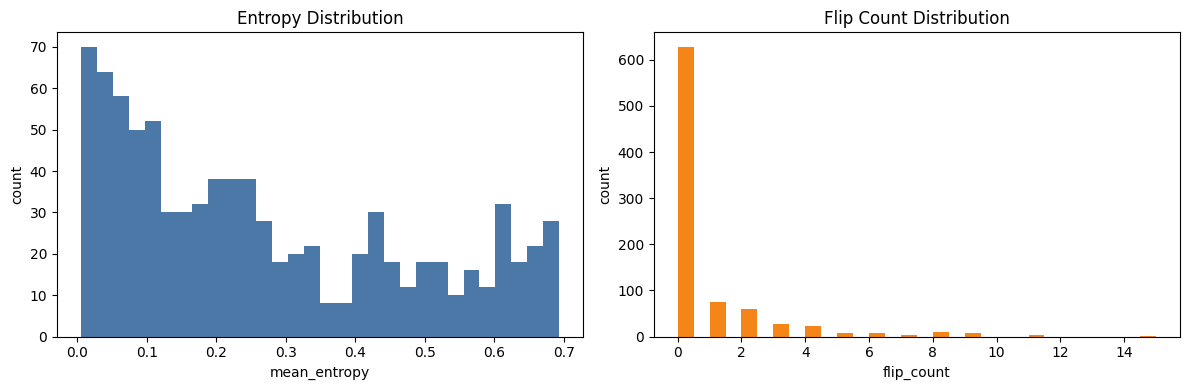

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(metrics['mean_entropy'].dropna(), bins=30, color='#4c78a8')
axes[0].set_title('Entropy Distribution')
axes[0].set_xlabel('mean_entropy')
axes[0].set_ylabel('count')

axes[1].hist(metrics['flip_count'].dropna(), bins=30, color='#f58518')
axes[1].set_title('Flip Count Distribution')
axes[1].set_xlabel('flip_count')
axes[1].set_ylabel('count')

plt.tight_layout()


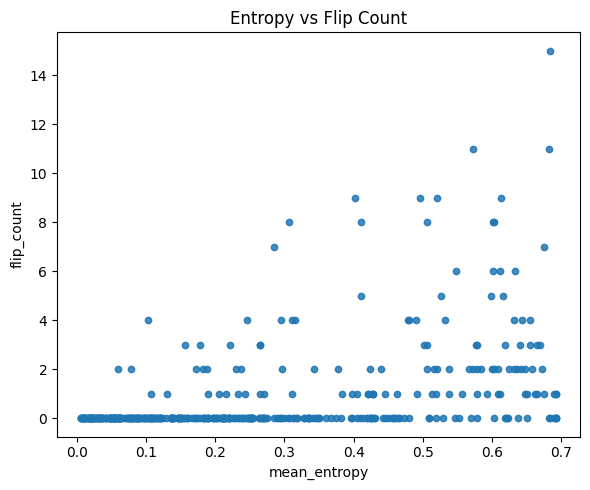

In [63]:
plt.figure(figsize=(6, 5))
plt.scatter(metrics['mean_entropy'], metrics['flip_count'], s=20, alpha=0.6)
plt.title('Entropy vs Flip Count')
plt.xlabel('mean_entropy')
plt.ylabel('flip_count')
plt.tight_layout()


## Feature engineering
We compute per-token metrics:
- Mean entropy of the price series
- Flip frequency across 0.5
- Belief velocity in the final window before resolution
- Early vs late PnL proxy (price change to final)
- Momentum autocorrelation and predictive power


In [64]:
def entropy(p):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return -(p * np.log(p) + (1 - p) * np.log(1 - p))

def flip_frequency(series):
    if len(series) < 2:
        return 0
    signs = np.sign(series - 0.5)
    # count sign changes ignoring zeros
    flips = 0
    prev = None
    for s in signs:
        if s == 0:
            continue
        if prev is not None and s != prev:
            flips += 1
        prev = s
    return flips

def belief_velocity(ts, prices, resolution_time):
    if len(prices) < 2:
        return np.nan
    if resolution_time is None:
        window_end = ts.iloc[-1]
    else:
        window_end = resolution_time
    window_start = window_end - pd.Timedelta(days=VELOCITY_DAYS)
    mask = (ts >= window_start) & (ts <= window_end)
    sub = prices[mask]
    if len(sub) < 2:
        return np.nan
    return np.mean(np.abs(np.diff(sub)))

def early_late_pnl(prices):
    if len(prices) < 2:
        return np.nan, np.nan
    n = len(prices)
    early_n = max(1, int(n * EARLY_FRAC))
    late_n = max(1, int(n * LATE_FRAC))
    early_price = np.mean(prices[:early_n])
    late_price = np.mean(prices[-late_n:])
    final_price = prices[-1]
    return abs(final_price - early_price), abs(final_price - late_price)

def momentum_metrics(prices):
    if len(prices) < 3:
        return np.nan, np.nan
    returns = np.diff(prices)
    if np.std(returns) == 0:
        return 0.0, 0.0
    autocorr = np.corrcoef(returns[:-1], returns[1:])[0, 1]
    # predictive power: correlation of return with future price change
    future_change = prices[2:] - prices[1:-1]
    pred = np.corrcoef(returns[:-1], future_change)[0, 1]
    return autocorr, pred

def get_resolution_time(markets_df, cid):
    if markets_df is None or markets_df.empty:
        return None
    rows = markets_df[markets_df.get('conditionId', markets_df.get('condition_id')) == cid]
    if rows.empty:
        return None
    for col in ['closedTime', 'endDate', 'endDateIso']:
        if col in rows.columns:
            val = rows.iloc[0].get(col)
            if pd.notna(val):
                return pd.to_datetime(val, utc=True, errors='coerce')
    return None

def _question_map(df):
    if df is None or df.empty:
        return {}
    q_col = 'question' if 'question' in df.columns else None
    if q_col is None:
        return {}
    if 'conditionId' in df.columns:
        cid_col = 'conditionId'
    elif 'condition_id' in df.columns:
        cid_col = 'condition_id'
    else:
        cid_col = None
    mapping = {}
    if cid_col:
        mapping.update(dict(zip(df[cid_col].astype(str), df[q_col])))
    if 'market_id' in df.columns:
        mapping.update(dict(zip(df['market_id'].astype(str), df[q_col])))
    if 'id' in df.columns:
        mapping.update(dict(zip(df['id'].astype(str), df[q_col])))
    return mapping


In [65]:
token_groups = prices_df.groupby('token_id')
rows = []

for token_id, g in token_groups:
    g = g.sort_values('timestamp')
    prices = g['price'].to_numpy()
    if len(prices) < MIN_POINTS:
        continue
    cid = g['conditionId'].iloc[0]
    resolution_time = get_resolution_time(markets_df, cid)
    mean_entropy = float(np.mean(entropy(prices)))
    flips = int(flip_frequency(prices))
    velocity = belief_velocity(g['timestamp'], prices, resolution_time)
    early_pnl, late_pnl = early_late_pnl(prices)
    autocorr, pred = momentum_metrics(prices)
    rows.append({
        'token_id': token_id,
        'conditionId': cid,
        'market_id': g['market_id'].iloc[0],
        'points': len(prices),
        'mean_entropy': mean_entropy,
        'flip_count': flips,
        'velocity': velocity,
        'early_pnl_proxy': early_pnl,
        'late_pnl_proxy': late_pnl,
        'autocorr': autocorr,
        'pred_power': pred,
        'final_price': prices[-1],
    })

metrics = pd.DataFrame(rows)
question_map = _question_map(markets_df)
metrics['question'] = metrics['conditionId'].astype(str).map(question_map)
metrics.loc[metrics['question'].isna(), 'question'] = metrics['market_id'].astype(str).map(question_map)
metrics.head()


,token_id,conditionId,market_id,points,mean_entropy,flip_count,velocity,early_pnl_proxy,late_pnl_proxy,autocorr,pred_power,final_price,question
0,1000051949190680041464720811079781086510675613...,0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,254129,19,0.201537,0,0.002107,0.484500,0.000000e+00,-0.104612,-0.104612,0.9945,"GRAMMYs 2024: Will ""A&W"" by Lana Del Rey win S..."
1,1000189674649713065386260116262477818323460361...,0x0ca7be2ec3c6fdddbc4fd183d6979d653e6270c6ac2b...,517414,14,0.672669,0,0.023462,0.125000,0.000000e+00,0.019108,0.019108,0.6250,Canucks vs. Maple Leafs
2,1000211317704275600989095869621047084745156630...,0x48ed22d2bef0381f300eff100118e2dc01bfe2b4920e...,253828,61,0.048749,0,0.000179,0.008083,8.333333e-05,0.033843,0.033843,0.0065,Will Sacramento Kings be 2023-24 NBA Champions?
3,1000747703786340566015724856532527028503636764...,0x2393ed0b0fdc450054c7b9071907eca75cf4fc36e385...,517313,792,0.342576,0,0.010393,0.213519,1.579747e-02,0.014508,0.014508,0.0330,"Will Trump deport 500,000-750,000- people?"
4,1001642493447151925668910251368195271528206049...,0x0c12d7b5322f432a0c4ac8806b476c7483c4d44061ca...,253723,615,0.023521,0,0.000000,0.029811,1.110223e-16,-0.177781,-0.177781,0.9995,Will Nikki Haley win the popular vote in the 2...


## 1) Informational vs trivial markets
- Low entropy implies near-certain outcomes (trivial).
- High entropy + high flip frequency implies informational (beliefs shifting).


In [66]:
entropy_q = metrics['mean_entropy'].quantile([0.25, 0.75]).to_dict()
flip_q = metrics['flip_count'].quantile([0.25, 0.75]).to_dict()

def classify(row):
    if row['mean_entropy'] <= entropy_q[0.25] and row['flip_count'] <= flip_q[0.25]:
        return 'trivial'
    if row['mean_entropy'] >= entropy_q[0.75] and row['flip_count'] >= flip_q[0.75]:
        return 'informational'
    return 'mixed'

metrics['info_class'] = metrics.apply(classify, axis=1)

metrics['info_class'].value_counts()


mixed            902
trivial          380
informational    262
Name: info_class, dtype: int64

In [69]:
metrics.sort_values(['info_class', 'mean_entropy'], ascending=[True, True]) [['info_class', 'question', 'conditionId', 'mean_entropy', 'flip_count']].head(10)


,info_class,question,conditionId,mean_entropy,flip_count
211,informational,Will weed be rescheduled in 2024?,0xe610902a9cbe5a4969466a5b853f9165fa071b9804aa...,0.495382,9
685,informational,Will weed be rescheduled in 2024?,0xe610902a9cbe5a4969466a5b853f9165fa071b9804aa...,0.495382,9
48,informational,Will Nikki Haley drop out before Super Tuesday?,0x734d34f1c177e102fd6049b9e78a94b4f6b40c3c7a64...,0.501638,3
236,informational,Will Nikki Haley drop out before Super Tuesday?,0x734d34f1c177e102fd6049b9e78a94b4f6b40c3c7a64...,0.501638,3
408,informational,Will Andrew Tate leave Romania before April?,0x9953104942de71b93a962162dfd5edc3fe673d26e1a4...,0.505432,5
593,informational,Will Andrew Tate leave Romania before April?,0x9953104942de71b93a962162dfd5edc3fe673d26e1a4...,0.505432,5
534,informational,Will the Kansas City Chiefs win Super Bowl LVIII?,0x0fd9ad6db40be7a9739483aec9d54dc37b2c88f30eee...,0.505484,3
856,informational,Will the Kansas City Chiefs win Super Bowl LVIII?,0x0fd9ad6db40be7a9739483aec9d54dc37b2c88f30eee...,0.505484,3
232,informational,Will another person be next prime minister of ...,0xc3eb889dbd5440e041dc8dc930696dd4a39ac65d12cd...,0.505510,2
1386,informational,Will another person be next prime minister of ...,0xc3eb889dbd5440e041dc8dc930696dd4a39ac65d12cd...,0.505510,2


## 2) Belief change precedes resolution
We look for high belief velocity in the final window before resolution.


In [70]:
metrics[['question', 'conditionId', 'token_id', 'velocity']].sort_values('velocity', ascending=False).head(10)


,question,conditionId,token_id,velocity
415,Will Jordan Henderson leave Saudi Arabia this ...,0x4d503712258580f01fbe95b052661d7522c5d0c4accf...,2457392130656000333213986570082339432037624576...,0.156393
492,Will Jordan Henderson leave Saudi Arabia this ...,0x4d503712258580f01fbe95b052661d7522c5d0c4accf...,2954876428010274655605578166501928604585980376...,0.156393
295,Will JD Vance win the 2024 Republican VP nomin...,0x6a031c4888fcfb886861d3616cce760ea284dbf46e35...,1676437974893341377645629331652291129378218985...,0.142643
1346,Will JD Vance win the 2024 Republican VP nomin...,0x6a031c4888fcfb886861d3616cce760ea284dbf46e35...,8740656239897996229946827952019049208887169296...,0.142643
1487,Will 'Dune: Part Two' gross between $80m-90m o...,0x45b4ecea87726c997c46358266818a11cdc6f6a68ff1...,9717962099768530109353438716551442695949923140...,0.140692
1205,Will 'Dune: Part Two' gross between $80m-90m o...,0x45b4ecea87726c997c46358266818a11cdc6f6a68ff1...,7745365686298750297173425412551336096127167231...,0.140692
194,Will Solana Network go down in January?,0xa835f053e4ff50c67b1a1147ec79ad159da93a6a8466...,1134554128982234934064347206592553053557065407...,0.129714
1282,Will Solana Network go down in January?,0xa835f053e4ff50c67b1a1147ec79ad159da93a6a8466...,8286750697612750061532131619885116889119577333...,0.129714
889,Will Ben Johnson be the head coach of the Cowb...,0x87a6804cd661fa0ec6d82ad4bb38eefe5f8044484123...,5777393008123783807065569840505297721838059970...,0.127536
1450,Will Ben Johnson be the head coach of the Cowb...,0x87a6804cd661fa0ec6d82ad4bb38eefe5f8044484123...,9517952436001899833995729543584806763309541352...,0.127536


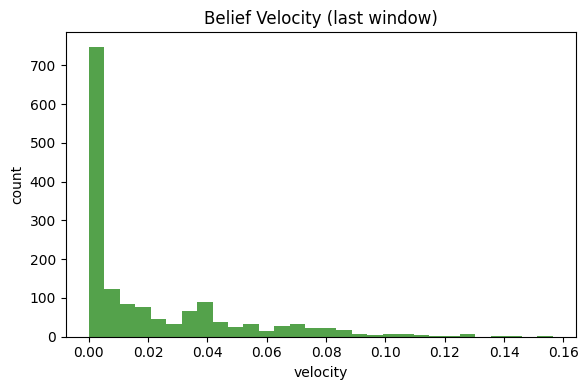

In [71]:
plt.figure(figsize=(6, 4))
plt.hist(metrics['velocity'].dropna(), bins=30, color='#54a24b')
plt.title('Belief Velocity (last window)')
plt.xlabel('velocity')
plt.ylabel('count')
plt.tight_layout()


## 3) Who moves prices first?
We compare early vs late PnL proxies. Higher early PnL suggests earlier information advantage.


In [72]:
metrics['early_vs_late'] = metrics['early_pnl_proxy'] - metrics['late_pnl_proxy']
metrics[['question', 'conditionId', 'token_id', 'early_pnl_proxy', 'late_pnl_proxy', 'early_vs_late']].sort_values('early_vs_late', ascending=False).head(10)


,question,conditionId,token_id,early_pnl_proxy,late_pnl_proxy,early_vs_late
807,Will 4-6 SpaceX Starship launches successfully...,0x28c29d67cfc9f03e71a8fcf743718de60ffceaab2198...,5154192968144418759645297467769902295583994733...,0.940104,0.009917,0.930188
907,Will 4-6 SpaceX Starship launches successfully...,0x28c29d67cfc9f03e71a8fcf743718de60ffceaab2198...,5902839303268150683100028808412202471613731477...,0.940104,0.009917,0.930187
1273,BTC ETFs first week combined AUM between $10-3...,0x7e799a35d58bbfe4f8e70b9ee908fb9f53f863f6cc93...,8206293132917947235914721856693089951013217765...,0.916500,0.000000,0.916500
1302,BTC ETFs first week combined AUM between $10-3...,0x7e799a35d58bbfe4f8e70b9ee908fb9f53f863f6cc93...,8415321650912308367138667848773116584466110632...,0.916500,0.000000,0.916500
979,Will A Minecraft Movie be the top grossing mov...,0xe87b10afe191706bb36b22526b65983e2a88a12ccce3...,6411557111266307188892959902700371502686662338...,0.939479,0.023438,0.916041
1095,Will A Minecraft Movie be the top grossing mov...,0xe87b10afe191706bb36b22526b65983e2a88a12ccce3...,7135021416102461795415419545594390879110674354...,0.939479,0.023438,0.916041
603,Trump margin of victory in New Hampshire Prima...,0x166ad5a3914c4dfaf4e8eb851f167c04797f2abbb342...,3759642455241592720598593282207202893563998173...,0.873500,0.004500,0.869000
61,Trump margin of victory in New Hampshire Prima...,0x166ad5a3914c4dfaf4e8eb851f167c04797f2abbb342...,1040512424955063651824023072598465600939791494...,0.873500,0.004500,0.869000
143,BTC ETFs first week combined AUM between $30-6...,0xca92ec28e43948c3b41a87ea94c74aea851924e085ff...,1108431960830363222591688163286098858792937957...,0.819500,0.000000,0.819500
1036,BTC ETFs first week combined AUM between $30-6...,0xca92ec28e43948c3b41a87ea94c74aea851924e085ff...,6805716277323278470958447819828273859267447203...,0.819500,0.000000,0.819500


## 4) When does momentum become noise?
Noise-like momentum: high autocorrelation with low predictive power or mean-reverting returns.


In [73]:
noise_candidates = metrics.copy()
noise_candidates['noise_score'] = noise_candidates['autocorr'] - noise_candidates['pred_power']
noise_candidates = noise_candidates.sort_values('noise_score', ascending=False)
noise_candidates[['question', 'conditionId', 'token_id', 'autocorr', 'pred_power', 'noise_score']].head(10)


,question,conditionId,token_id,autocorr,pred_power,noise_score
0,"GRAMMYs 2024: Will ""A&W"" by Lana Del Rey win S...",0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,1000051949190680041464720811079781086510675613...,-0.104612,-0.104612,0.0
1061,BTC ETFs first week combined AUM over $60 bill...,0x9fe78759b4412e42a81e2ada75a35360d14938eb8460...,6938060178798106400871798884784386635943524760...,0.951267,0.951267,0.0
1035,Will Mark Ruffalo win the Oscar for Best Suppo...,0xb43b47e2a417a605a58e964b8eb28b160171635c122a...,6805176161122423222428128018075641567840071136...,-0.499802,-0.499802,0.0
1034,Lions vs. Buccaneers,0xd170ab0ce9d2bce050d84387508315e226a231943593...,6804443318997161463388375272900166174230897886...,-0.136296,-0.136296,0.0
1033,BTC ETFs first week combined AUM under $10 bil...,0xf1c1fcc3efe839e5a022574c0263cb967ee3355f6b58...,6793995311897407355016066268978286310774045708...,-0.397380,-0.397380,0.0
1032,Will Los Angeles Lakers be 2023-24 NBA Champions?,0x54973fc6a15a89d137f7eb42db9cc4d957cf217956bf...,6788434641257014093184240462509531417134659063...,0.080571,0.080571,0.0
1031,Starmer inquiry into grooming gangs before Feb...,0xd94a988351508b16f29396a8b9e469f5fd098e80d719...,6781091233916119267071653916744975164894977338...,0.186079,0.186079,0.0
1030,Will another candidate win the 2024 Republican...,0xdd9416a1ca64e689cd0787a801176885f65219a6c3cc...,6764578024995466576685045599072690770209995207...,-0.737428,-0.737428,0.0
1029,Will Taylor Swift attend the Super Bowl?,0xb73c1524d4f6bb61b58056ebb23d90470c7db546080b...,6759605529716551239521521014590145225735189573...,0.114253,0.114253,0.0
1028,Will the Patriots make the first pick of the 2...,0xcd4bad1eafe59039ae16216a5e38e45d56c66f5911fe...,6718600044456245584768577406851322369812688693...,-0.139920,-0.139920,0.0


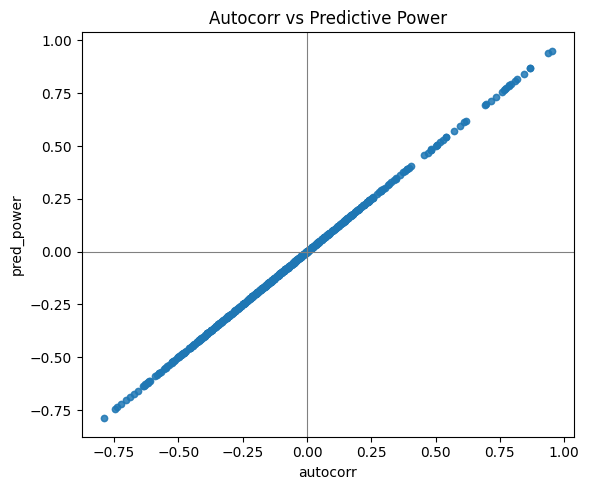

In [74]:
plt.figure(figsize=(6, 5))
plt.scatter(metrics['autocorr'], metrics['pred_power'], s=20, alpha=0.6)
plt.title('Autocorr vs Predictive Power')
plt.xlabel('autocorr')
plt.ylabel('pred_power')
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()


## Summary tables
These tables are token-level. If you want market-level rollups, we can aggregate by `conditionId`.


In [75]:
metrics.describe(include='all').transpose().head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
token_id,1544,1544,1000051949190680041464720811079781086510675613...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conditionId,1544,772,0x0bda34ac035c772bd7986ca874f2e7c2440c4add176d...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
market_id,1544,772,254129,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,1544.0,NaN,NaN,NaN,176.632772,223.390484,10.0,19.0,66.0,225.0,792.0
mean_entropy,1544.0,NaN,NaN,NaN,0.30177,0.220039,0.005399,0.104187,0.250832,0.493134,0.693121
flip_count,1544.0,NaN,NaN,NaN,1.189119,3.162152,0.0,0.0,0.0,1.0,37.0
velocity,1544.0,NaN,NaN,NaN,0.020634,0.028125,0.0,0.000786,0.005857,0.034433,0.156393
early_pnl_proxy,1544.0,NaN,NaN,NaN,0.198396,0.210166,0.0,0.030188,0.123706,0.3205,0.972691
late_pnl_proxy,1544.0,NaN,NaN,NaN,0.036849,0.098148,0.0,0.0,0.001354,0.015091,0.719265
autocorr,1544.0,NaN,NaN,NaN,-0.078701,0.264959,-0.789197,-0.226691,-0.076397,0.034886,0.951267
